# Stanford Dog Dataset Case Study

In [64]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
!wget --header="Host: vision.stanford.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.190 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,hi;q=0.8" --header="Referer: http://vision.stanford.edu/aditya86/ImageNetDogs/main.html" --header="Cookie: __utmc=18943295; __utmz=18943295.1614845323.1.1.utmcsr=(direct)|utmccn=(direct)|utmcmd=(none); __utma=18943295.1219152693.1614845323.1614845323.1614859681.2; __utmb=18943295.4.10.1614859681" --header="Connection: keep-alive" "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar" -c -O 'images.tar'

--2021-03-04 12:28:12--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  37.4MB/s    in 22s     

2021-03-04 12:28:34 (34.6 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [2]:
!7z x images.tar


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 793579520 bytes (757 MiB)

Extracting archive: images.tar
  4% 1024 Open              --
Path = images.tar
Type = tar
Physical Size = 793579520
Headers Size = 10602496
Code Page = UTF-8

 98%      8% 1988 - Images/n02088238-basset/n02088238_665.jpg                                                      16% 3747 - Images/n02091134-whippet/n02091134_3263.jpg                                                        21% 4821 - Images/n02092339-Weimaraner/n02092339_4633.jpg

## Import Packages

In [89]:
import os
import io
import random
import re
import requests

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras import applications, layers, models, optimizers, callbacks

## Helper Functions

In [41]:
def read_img(image_path):

  '''Function to generate an image using the file path'''

  img = Image.open(image_path)
  return img

In [43]:
def print_random_images(type_of_breed):

  '''Function to randomly display 9 images in a 3x3 grid'''

  fig=plt.figure(figsize=(10, 10))
  columns = 3
  rows = 3
  title = ""
  
  for i in range(1, columns * rows +1):
      dog = random.choice(type_of_breed)
      dir_path = os.path.join('/content/Images', dog)
      location = os.path.join(dir_path, random.choice(os.listdir(dir_path)))
      img = read_img(location)
      title = re.search(r'\-(.*)', dog)
          
      axes = fig.add_subplot(rows, columns, i, title=title.group(0))
      fig.tight_layout(pad=1.0)
      axes.axis('off')
      title = ""
  
      plt.imshow(img)
      
  plt.show()

In [74]:
def plot_accuracy(history):

  '''Function to plot accuracy graph'''
  
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')

In [76]:
def plot_loss(history):

  '''Function to plot loss graph'''

  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')

In [87]:
def predict_breed(image_path, breed_list, model):

  '''Function to display the breed of the dog for the given image'''

  response = requests.get(image_path)
  img = Image.open(io.BytesIO(response.content))
  
  img = img.resize((299, 299))
  img = np.array(img) / 255
  
  pred = np.argmax(model.predict(img.reshape(1, 299, 299, 3)), axis=1)
  plt.title("Predicted: " + re.search(r'\-(.*)', breed_list[int(pred)]).group(0))
  plt.axis('off')
  plt.imshow(img)

## Exploratory Data Analysis

In [5]:
type_of_breed = os.listdir('/content/Images')
print("Total number of breeds: ", len(type_of_breed))

Total number of breeds:  120


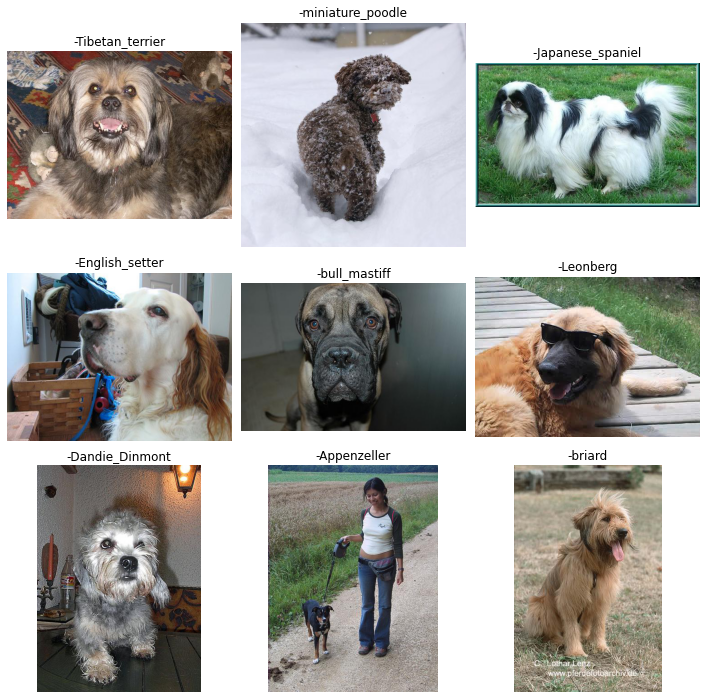

In [44]:
print_random_images(type_of_breed)

## Data Preprocessing

In [46]:
data_generator = image.ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,    
    horizontal_flip=True,
    validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    '/content/Images',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=0)

validation_generator = data_generator.flow_from_directory(
    '/content/Images',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=0)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


## Model Building

In [66]:
inception_model = applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

for layer in inception_model.layers:
  layer.trainable = False

inception_final_layer = inception_model.output
batch_norm_layer = layers.BatchNormalization(name='batch_norm_layer')(inception_final_layer)
glob_avg_pool_layer = layers.GlobalAveragePooling2D(name='glob_avg_pool_layer')(batch_norm_layer)
softmax_layer = layers.Dense(120, activation='softmax', name='softmax_layer')(glob_avg_pool_layer)

model = models.Model(inputs=inception_model.input, outputs=softmax_layer)

In [67]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 149, 149, 32) 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 149, 149, 32) 0           batch_normalization_282[0][0]    
____________________________________________________________________________________________

In [68]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

## Model Training

In [69]:
filepath = "/content/gdrive/My Drive/stanford_dog/inception_epoch:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor="val_accuracy", save_best_only=True, verbose=1)

In [70]:
callback_list = [checkpoint]

In [71]:
with tf.device('/device:GPU:0'):
  history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=6,
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator),
      callbacks=callback_list
  )

Epoch 1/6
516/516 [==============================] - 415s 796ms/step - loss: 3.4937 - accuracy: 0.3680 - val_loss: 0.9101 - val_accuracy: 0.8394

Epoch 00001: val_accuracy improved from -inf to 0.83939, saving model to /content/gdrive/My Drive/stanford_dog/inception_epoch:001-val_accuracy:0.839.h5
Epoch 2/6
516/516 [==============================] - 404s 783ms/step - loss: 0.7642 - accuracy: 0.8620 - val_loss: 0.5043 - val_accuracy: 0.8725

Epoch 00002: val_accuracy improved from 0.83939 to 0.87254, saving model to /content/gdrive/My Drive/stanford_dog/inception_epoch:002-val_accuracy:0.873.h5
Epoch 3/6
516/516 [==============================] - 404s 784ms/step - loss: 0.4704 - accuracy: 0.8863 - val_loss: 0.4327 - val_accuracy: 0.8765

Epoch 00003: val_accuracy improved from 0.87254 to 0.87647, saving model to /content/gdrive/My Drive/stanford_dog/inception_epoch:003-val_accuracy:0.876.h5
Epoch 4/6
516/516 [==============================] - 404s 783ms/step - loss: 0.3742 - accuracy: 0

## Model Performance

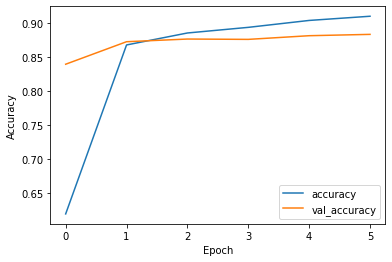

In [73]:
plot_accuracy(history)

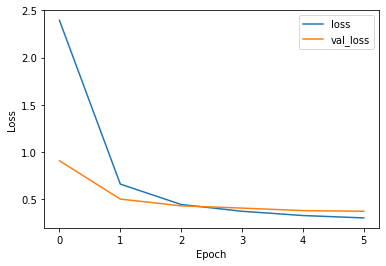

In [77]:
plot_loss(history)

## Make Predictions

In [80]:
breed_list = list(train_generator.class_indices.keys())
print("List of all the dog breeds:")
print(breed_list)

List of all the dog breeds:
['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terr

In [82]:
best_model = models.load_model('/content/gdrive/MyDrive/stanford_dog/inception_epoch:006-val_accuracy:0.883.h5')

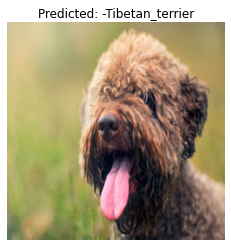

In [92]:
predict_breed("https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/04/12185602/Lagotto-Romangolo-Tongue-Out.jpg", breed_list, best_model)

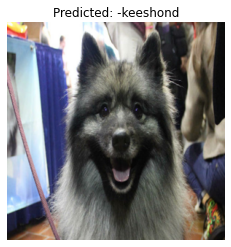

In [93]:
predict_breed("http://cdn.akc.org/content/article-body-image/keeshond_dog_pictures.jpg", breed_list, best_model)

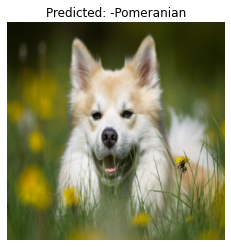

In [95]:
predict_breed("http://cdn.akc.org/content/article-body-image/icelandic_sheepdog_dog_picture.jpg", breed_list, best_model)